In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
## read data
data0_01 = pd.read_csv(r'D:\kul\Modern Data Analytics\2\assignment\data\csv_results_40_255439_mp-01-naamsestraat-35-maxim.csv',sep=';')
data0_02 = pd.read_csv(r'D:\kul\Modern Data Analytics\2\assignment\data\csv_results_40_255440_mp-02-naamsestraat-57-xior.csv',sep=';')
data0_03 = pd.read_csv(r'D:\kul\Modern Data Analytics\2\assignment\data\csv_results_40_255441_mp-03-naamsestraat-62-taste.csv',sep=';')
data0_04 = pd.read_csv(r'D:\kul\Modern Data Analytics\2\assignment\data\csv_results_40_303910_mp-04-his-hears.csv',sep=';')
data0_05 = pd.read_csv(r'D:\kul\Modern Data Analytics\2\assignment\data\csv_results_40_255442_mp-05-calvariekapel-ku-leuven.csv',sep=';')
data0_06 = pd.read_csv(r'D:\kul\Modern Data Analytics\2\assignment\data\csv_results_40_255443_mp-06-parkstraat-2-la-filosovia.csv',sep=';')
data0_07 = pd.read_csv(r'D:\kul\Modern Data Analytics\2\assignment\data\csv_results_40_255444_mp-07-naamsestraat-81.csv',sep=';')
data0_08 = pd.read_csv(r'D:\kul\Modern Data Analytics\2\assignment\data\csv_results_40_280324_mp08bis---vrijthof.csv',sep=';')

In [3]:
data_frames = {'data0_01': data0_01, 'data0_02': data0_02, 'data0_03': data0_03, 'data0_04': data0_04, 
               'data0_05': data0_05, 'data0_06': data0_06, 'data0_07': data0_07, 'data0_08': data0_08}

for df in data_frames.items():
    # Convert datetime column to datetime format and create separate date and time columns
    df[1]['timestamp'] = pd.to_datetime(df[1]['result_timestamp'], format='%d/%m/%Y %H:%M:%S.%f')
    df[1].set_index('timestamp', inplace=True)
     
cols = ['laf005_per_hour', 'laf01_per_hour', 'laf05_per_hour', 'laf10_per_hour',
        'laf25_per_hour', 'laf50_per_hour', 'laf75_per_hour', 'laf90_per_hour',
        'laf95_per_hour', 'laf98_per_hour', 'laf99_per_hour', 'laf995_per_hour']
    
data0_01s = data0_01[cols]
data0_02s = data0_02[cols]
data0_03s = data0_03[cols]
data0_04s = data0_04[cols]
data0_05s = data0_05[cols]
data0_06s = data0_06[cols]
data0_07s = data0_07[cols]
data0_08s = data0_08[cols]

# Denoising


In [4]:
rolling_avg_data0_01 = data0_01s.rolling(2).mean()
rolling_avg_data0_02 = data0_02s.rolling(2).mean()
rolling_avg_data0_03 = data0_03s.rolling(2).mean()
rolling_avg_data0_04 = data0_04s.rolling(2).mean()
rolling_avg_data0_05 = data0_05s.rolling(2).mean()
rolling_avg_data0_06 = data0_06s.rolling(2).mean()
rolling_avg_data0_07 = data0_07s.rolling(2).mean()
rolling_avg_data0_08 = data0_08s.rolling(2).mean()

rolling_avg_data0_01['result_timestamp'] = data0_01['result_timestamp']
rolling_avg_data0_02['result_timestamp'] = data0_02['result_timestamp']
rolling_avg_data0_03['result_timestamp'] = data0_03['result_timestamp']
rolling_avg_data0_04['result_timestamp'] = data0_04['result_timestamp']
rolling_avg_data0_05['result_timestamp'] = data0_05['result_timestamp']
rolling_avg_data0_06['result_timestamp'] = data0_06['result_timestamp']
rolling_avg_data0_07['result_timestamp'] = data0_07['result_timestamp']
rolling_avg_data0_08['result_timestamp'] = data0_08['result_timestamp']


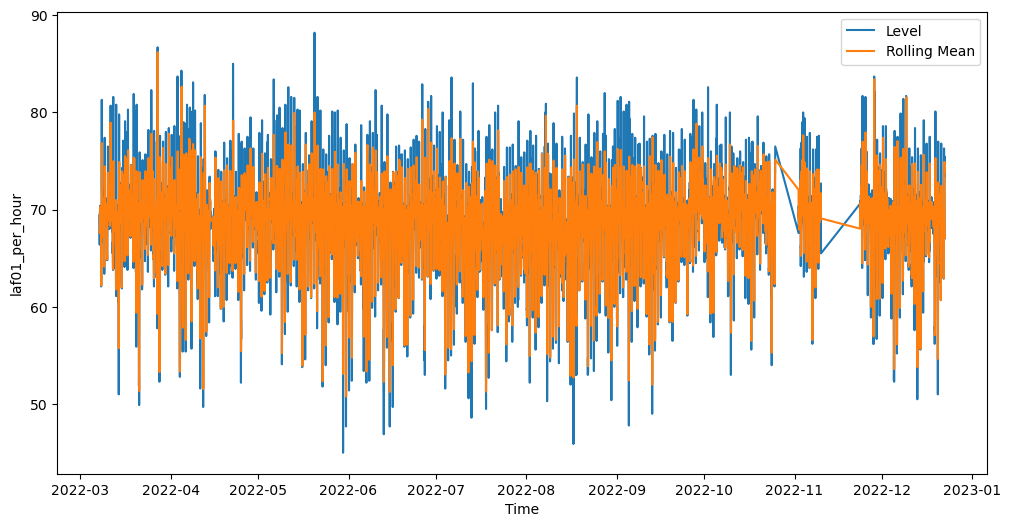

In [5]:
# Set the figure size
plt.figure(figsize=(12, 6))

plt.plot(data0_02s.index, data0_02s['laf01_per_hour'])
plt.plot(data0_02s.index, rolling_avg_data0_02['laf01_per_hour'])
plt.xlabel('Time')
plt.ylabel('laf01_per_hour')
plt.legend(['Level','Rolling Mean'])
plt.show()

# Imputation


In [6]:
# Imputation #
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt


In [7]:
def impute_and_compare(df, n=200, missing_rate=0.08):
    data = df.drop("result_timestamp", axis=1)

    # Select a random subset of rows from the DataFrame
    full = data.sample(n=n, random_state=27)

    # Insert missingness
    n_samples = full.shape[0]
    n_features = full.shape[1]
    rng = np.random.RandomState(0)
    n_missing_samples = int(np.floor(n_samples * n_features * missing_rate))

    missing_features = rng.randint(0, n_features, n_missing_samples)
    missing_samples = rng.randint(0, n_samples, n_missing_samples)

    miss = full.copy()
    miss.values[missing_samples, missing_features] = np.nan

    # Impute with mean
    imputer = SimpleImputer(strategy='mean')
    mean = pd.DataFrame(imputer.fit_transform(miss), columns=miss.columns)
    mean = np.round(mean)

    # KNN imputation
    imputer = KNNImputer()
    knn = pd.DataFrame(imputer.fit_transform(miss), columns=miss.columns, index=miss.index)
    knn = np.round(knn)

    # MICE imputation
    imputer = IterativeImputer()
    mice = pd.DataFrame(imputer.fit_transform(miss), columns=miss.columns, index=miss.index)
    mice = np.round(mice)

    # Calculate RMSE
    rmse_mean = sqrt(mean_squared_error(full, mean))
    rmse_knn = sqrt(mean_squared_error(full, knn))
    rmse_mice = sqrt(mean_squared_error(full, mice))

    # Calculate R2
    r2_mean = r2_score(full, mean)
    r2_knn = r2_score(full, knn)
    r2_mice = r2_score(full, mice)

    # Print results
    print("RMSE for mean imputation:", rmse_mean)
    print("RMSE for knn imputation:", rmse_knn)
    print("RMSE for MICE imputation:", rmse_mice)

    print("r2 for mean imputation:", r2_mean)
    print("r2 for knn imputation:", r2_knn)
    print("r2 for MICE imputation:", r2_mice)


In [8]:
## compare imputation
impute_and_compare(rolling_avg_data0_01)
impute_and_compare(rolling_avg_data0_02)
impute_and_compare(rolling_avg_data0_03)
impute_and_compare(rolling_avg_data0_04)
impute_and_compare(rolling_avg_data0_05)
impute_and_compare(rolling_avg_data0_06)
impute_and_compare(rolling_avg_data0_07)
impute_and_compare(rolling_avg_data0_08)

RMSE for mean imputation: 1.6698705663413942
RMSE for knn imputation: 0.45976556526125256
RMSE for MICE imputation: 0.3200406875174867
r2 for mean imputation: 0.9003983224840885
r2 for knn imputation: 0.9921191557758758
r2 for MICE imputation: 0.9963363285867421
RMSE for mean imputation: 1.3666042922758095
RMSE for knn imputation: 0.3998215747888874
RMSE for MICE imputation: 0.3014254330123223
r2 for mean imputation: 0.9047064071975837
r2 for knn imputation: 0.9907863555120916
r2 for MICE imputation: 0.9948014165736091
RMSE for mean imputation: 1.0580165208224936
RMSE for knn imputation: 0.3832196389365588
RMSE for MICE imputation: 0.30294216994887496
r2 for mean imputation: 0.9008343276079184
r2 for knn imputation: 0.9836840567861295
r2 for MICE imputation: 0.9883089280548254
RMSE for mean imputation: 0.9729658267380206
RMSE for knn imputation: 0.3820940111194269
RMSE for MICE imputation: 0.3029645193747933
r2 for mean imputation: 0.9399409863503293
r2 for knn imputation: 0.9895357160

D:\programme\anacoda\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
D:\programme\anacoda\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


RMSE for mean imputation: 1.492129350961236
RMSE for knn imputation: 0.4187680344375231
RMSE for MICE imputation: 0.29817500454151574
r2 for mean imputation: 0.9099645566438989
r2 for knn imputation: 0.990587039800631
r2 for MICE imputation: 0.9957105115081153
RMSE for mean imputation: 1.7262196775034169
RMSE for knn imputation: 0.40244176597366055
RMSE for MICE imputation: 0.3133837503764336
r2 for mean imputation: 0.9059767235720336
r2 for knn imputation: 0.9945444669680418
r2 for MICE imputation: 0.9967051937574491


D:\programme\anacoda\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


RMSE for mean imputation: 1.7146327959653642
RMSE for knn imputation: 0.4042057541236466
RMSE for MICE imputation: 0.29820120444648207
r2 for mean imputation: 0.9248031553331972
r2 for knn imputation: 0.9952285932743142
r2 for MICE imputation: 0.9973360246448948
RMSE for mean imputation: 0.9985917167024103
RMSE for knn imputation: 0.40581451017264836
RMSE for MICE imputation: 0.3192732633132105
r2 for mean imputation: 0.9075484254839957
r2 for knn imputation: 0.9840593012664186
r2 for MICE imputation: 0.9896206459396232


D:\programme\anacoda\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [9]:
def impute_data(df, imputer):
    data = df.drop("result_timestamp", axis=1)

    # Create a new DataFrame with hourly timestamps
    hourly_index = pd.date_range(start=data.index.min(), end=data.index.max(), freq='H')
    new_data = pd.DataFrame(index=hourly_index)

    # Merge the new DataFrame with the original data
    merged_data = pd.merge(data, new_data, left_index=True, right_index=True, how='outer')

    # Sort the index of the merged data
    merged_data = merged_data.sort_index()

    # Impute missing values
    imputed_data = pd.DataFrame(imputer.fit_transform(merged_data), columns=merged_data.columns, index=merged_data.index)
    #imputed_data = np.round(imputed_data)

    return imputed_data


In [10]:
## apply MICE
impu0_01 = impute_data(rolling_avg_data0_01,IterativeImputer())
impu0_02 = impute_data(rolling_avg_data0_02,IterativeImputer())
impu0_03 = impute_data(rolling_avg_data0_03,IterativeImputer())
impu0_04 = impute_data(rolling_avg_data0_04,IterativeImputer())
impu0_05 = impute_data(rolling_avg_data0_05,IterativeImputer())
impu0_06 = impute_data(rolling_avg_data0_06,IterativeImputer())
impu0_07 = impute_data(rolling_avg_data0_07,IterativeImputer())
impu0_08 = impute_data(rolling_avg_data0_08,IterativeImputer())

In [ ]:
impu0_01.to_csv(r'D:\kul\Modern Data Analytics\2\assignment\data_pro\noise40_1.csv', index=True)
impu0_02.to_csv(r'D:\kul\Modern Data Analytics\2\assignment\data_pro\noise40_2.csv', index=True)
impu0_03.to_csv(r'D:\kul\Modern Data Analytics\2\assignment\data_pro\noise40_3.csv', index=True)
impu0_04.to_csv(r'D:\kul\Modern Data Analytics\2\assignment\data_pro\noise40_4.csv', index=True)
impu0_05.to_csv(r'D:\kul\Modern Data Analytics\2\assignment\data_pro\noise40_5.csv', index=True)
impu0_06.to_csv(r'D:\kul\Modern Data Analytics\2\assignment\data_pro\noise40_6.csv', index=True)
impu0_07.to_csv(r'D:\kul\Modern Data Analytics\2\assignment\data_pro\noise40_7.csv', index=True)
impu0_08.to_csv(r'D:\kul\Modern Data Analytics\2\assignment\data_pro\noise40_8.csv', index=True)
